In [20]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy as sp
import glob
import pickle as pckl
import tqdm 
import tensorflow as tf

import numpy as np
from collections import Counter
import math as math
import functools

%matplotlib inline
%precision 4
plt.style.use('ggplot')

# DD2447: Statistical Methods in Applied Computer Science 

## Assignemnt 2

### Task 2.4: Gibbs sampler for the magic word

The following generative model magic word generates $N$ sequences if length $M$, $s^1, ..., s^N $ where $s^n = s_1^n, ... ,s_M^n $. All seqences are over the alphabet $[K]$. Each of these sequences has a "magic" word of length W hidden in it and tge rest of the sequence is called background. 

First, for each $n$, a start position $r_n$ for the magic word is sampled uniformly from $[M-w+1]$. Then the $j$:th positions in the word are sampled from $q_j(x)=Cat(x \mid \theta_j)$ where $\theta_j$ has a $Dir( \theta_j \mid \alpha)$ prior. All other positions in the sequences are sampled from the background distribution $q(x) = Cat(x \mid \theta)$ where $\theta$ has a $Dir(\theta \mid \alpha') prior.$

We are interestd in the posterior $p(r_1,...,r_N \mid D)$ where $D$ is the set of sequences $ s^1, ..., s^N$ generated by the model and the $r_n$ is the start position of the magic word in the $n$:th sequence $s^n$. The following describes a Gibbs sampler that can be used for estimating the posterior over start positions after having observed $s^1, ..., s^N$. The sampler that can be used for estimating the posterior over start postitions and $\alpha'$. The states are vectors of start position $R= (r_1,...,r_N)$

Notice that, for the Dirchlet-categorical (Dirichlet-multinoulli) distribution for the $j$:th position of the magic words, the marginal likelihood is 

$$ p(D_j \mid R) = \frac{\Gamma(\sum_k \alpha_k)}{\Gamma(N \sum_k \alpha_k)} \prod_k \frac{\Gamma( N_k^j + \alpha_k)}{\Gamma(\alpha_k)} $$

where $N_k^j$ is the count of the symbol $k$ in the $j$:th column of the magic words, introduced by $R$. For the background, the marginal likelihood is 

$$ p(D_B \mid R) = \frac{\Gamma(\sum_k \alpha_k')}{\Gamma(B \sum_k \alpha_k')} \prod_k \frac{\Gamma( B_k + \alpha_k')}{\Gamma(\alpha_k')} $$

where $B$ is the number of background positions (i.e. $N(M-w)$) and $B_k$ is the count of symbol $k$ in the background, induced by $R$. The full condition $p(r_n \mid R_{-n}, D)$ can be expressed as follows

\begin{align*}
p(r_n \mid R_{-n}, D) &= \frac{p(R_{-n} \cup r_n, D)}{p(R_{-n}, D)} \\
& \propto p(R_{-n} \cup r_n, D) \\
& \propto p(D \mid R_{-n} \cup r_n) \\
& = p(D_B \mid R_{-n} \cup r_n) \prod_j p(D_j \mid R_{-n} \cup r_n)
\end{align*}


#### Answers:

**Question 11:** Implement a Gibbs sampler for the magic word model described above. You are also supposed to generate synthetic data and estimate the posterior using Gibbs sampler.

The task consists of two practical parts: implementing the data generator and implementing the Gibbs sampler. 

Data generator needs to produce $N$ sequences, each of length $M$. Every element in the sequence will be a token over the alphabeth of size $K$. In our experients the alphabeth will consist of letters $a,b,c,d,e$, therefore $K$ being equal to $5$. 

The proces of generating data starts by first sampling a background for each sequence using the Dirichlet prior $\alpha'$. Then we uniformly choose a position of the start of the magic word $p_{mw} \sim U(0, M-W+1)$ and sample for the magic word tokens from Dirichlet distribution with prior $\alpha$.



The implementation of the data generator:

In [2]:
class DataGenerator:
    
    def __init__(self, alphabet = ['a', 'b', 'c','d','e'], alpha = [1,1,1,1,1], alpha_prime = [1,1,1,1,1],M=10,W=5):
        self.alphabet = alphabet
        self.alpha = alpha
        self.alpha_prime = alpha_prime
        self.M = M
        self.W = W
        self.generate_new_parameters()
        
    def generate_sequences(self,N = 5,gen_new_params=False):
        if gen_new_params:
            self.generate_new_parameters()
            
        sample = []
        positions=[]
        for i in range(N): 
            seq =[]
            pos = np.random.randint(0, self.M-self.W+1) # random positions for magic words
            for j in range(self.M):
                if pos <= j and j < pos+self.W: # sample for magic words
                    seq.append(self.sample(self.thetas_magic[j-pos])) 
                else: #sample for background
                    seq.append(self.sample(self.theta_back))
                    
            sample.append(seq)
            positions.append(pos)
                
        return sample, positions
    
    def sample(self,categorical):
        return self.alphabet[np.argmax(np.random.multinomial(1,categorical))]
    
    def generate_new_parameters(self):
        #background
        self.theta_back = np.random.dirichlet(self.alpha_prime)
        #magic-word
        self.thetas_magic = np.random.dirichlet(self.alpha, self.W)


Next comes the Gibbs sampler which we want to use to find the start positions of the magic words in sequences. We use $r_n$ to denote the start position of the magic word in the $n^{th}$ sequence. Therefore we estimate $p(r_1,...,r_n \mid \mathcal{D})$ where $\mathcal{D}$ is the generated data, i.e. the provided sequences.

The task requiers of us to use collapsed Gibbs sampler, which supports scenarios where some of the unknow quantities are analytically integrated. This method is also much more efficient, since it is sampling in a lower dimensional space. In our case $\alpha$ and $\alpha'$ are know parameters but the sequences are sampled from Multinomial distribution of paramether $\theta$, generated from $\alpha'$ used for background symbols and $\theta_j$, generated from $\alpha$ used for magic words symobls per position $j \in [1,..,W]$. Therefore we will integrate out the $\theta$ and $\theta_j$ parameters, which will cause all the symbols in sequences to become inter-dependent.

The initial state $R^{(0)} = r_1^0, ..., r_n^0$ is initialised randomly  and they will be resampled in the Gibbs sampling process. 

In each iteration of the sampling process we calculate the probability of each proposed position $r_n^{(i)}$ of being the real starting position of the magic word using:

$$ p(r_n^{(i)} \mid \mathcal{R}_{-n}^{(i)}, \mathcal{D}) \propto p(\mathcal{D}_{B} \mid \mathcal{R}^{(i)}, \alpha') \prod_{j=l}^{l+W} p(\mathcal{D}_j \mid \mathcal{R}^{(i)}, \alpha)$$ 

In the above equation $r_n^{(i)}$ denotes a vector of size $| M-W+1 |$ of proabilities of every valid position being the starting one, for the $n^{th}$ sequence. 


In order to get a more numerically stable probability measure we will apply the $log$ function to the probability functions. Distribution for the $j$:th position of the magic words now looks like:

$$ p(D_j \mid R) = \left[log\left(\Gamma(\sum_k \alpha_k) \right) - log\left(\Gamma(N \sum_k \alpha_k)\right) \right] \sum_k \left[ log\left(\Gamma( N_k^j + \alpha_k)\right) - log\left(\Gamma(\alpha_k)\right) \right] $$

where $N_k^j$ is the count of the symbol $k$ in the $j$:th column of the magic words, introduced by $R$. The log-background marginal likelihood is calculated as

$$ p(D_B \mid R) = \left[ log\left(\Gamma(\sum_k \alpha_k') \right) - log\left(\Gamma(B \sum_k \alpha_k')\right) \right] \sum_k \left[ log\left(\Gamma( B_k + \alpha_k')\right) - log\left(\Gamma(\alpha_k') \right) \right] $$

where $B$ is the number of background positions (i.e. $N(M-w)$) and $B_k$ is the count of symbol $k$ in the background, induced by $R$.


The generated vector is used as the parameter of the categorical distribution from which we sample the new starting positions $r_n^{(i+1)}$ and we do this through burn-in phase after which we can sample from the target distribution.

In [21]:
class GibbsSampler:
    
    def __init__(self,alphabet,data,alpha, alpha_prime, W):
        self.alphabet    = alphabet
        self.data        = data
        self.alpha       = alpha
        self.alpha_prime = alpha_prime
        self.W           = W
        self.N           = len(self.data)
        self.M           = len(self.data[0])
        self.K           = len(self.alphabet)
        self.B           = self.N * (self.M - self.W)

    def p_background(self,positions,display=False):
        if display:
            print('backgorund')
        seq_backgrounds = [ self.data[n][0:positions[n]] + self.data[n][positions[n]+self.W:] for n in range(self.N)]
        B = Counter([token for seq in seq_backgrounds for token in seq])
        
        sum_alpha_prime = sum(self.alpha_prime)
        C = math.lgamma(sum_alpha_prime ) - math.lgamma(self.B*sum_alpha_prime )
        if display:
            print('C=',C)
        
        class_probs = [ math.lgamma(B[self.alphabet[k]] + self.alpha_prime[k]) - math.lgamma(self.alpha_prime[k])  for k in range(self.K)]
        if display:
            print('classes: ',class_probs)
        
        p = C + sum(class_probs) 
        if display:
            print('p=',p)
        
        return p
        
    
    def p_magicword(self,positions,display=False):
        if display:
            print('magic word')
        seq_magic_words = [ self.data[n][positions[n]:positions[n]+self.W] for n in range(self.N)]
        seq_magic_words = np.array(seq_magic_words)
        
        N_j = [ Counter(seq_magic_words[:,w]) for w in range(self.W)]
        
        sum_alpha = sum(self.alpha)
        C = math.lgamma(sum_alpha )  - math.lgamma(self.N*self.W*sum_alpha)
        if display:
            print('C=',C)

        class_probs_j = []
        for j in range(self.W):
            class_probs_jk = [ math.lgamma(N_j[j][self.alphabet[k]] + self.alpha[k]) - math.lgamma(self.alpha[k])  for k in range(self.K) ]
            if display:
                print('classes{} = '.format(j),class_probs_jk)

            class_probs_jk = C + sum(class_probs_jk) 
            if display:
                print('p{} = '.format(j),class_probs_jk)
            class_probs_j.append(class_probs_jk)
            
        return class_probs_j

        
    def estimate_posterior(self, sequence_id, prev_positions,display=False):
        # number of background positions
        pos_proba = []
        if display:
            print('estimate')
        for r_i in range(M - self.W):
            positions = list(prev_positions)
            positions[sequence_id] = r_i
            #print(positions)
            
            p_b = self.p_background(positions)
            p_mw = self.p_magicword(positions)
            p =  p_b + sum(p_mw) 
            if display:
                print('P( r_i = {} ) = {}'.format(r_i,p))
            pos_proba.append(p)
            
        #print(pos_proba)
        if display:
            print('---')
        return pos_proba
    
    def _normalize(self,p):
        p = np.exp(p - np.max(p))
        p = p / np.sum(p)
        return p
    
    def sampler(self, sample_count = 100, min = 50, step = 10,display=False):

        iterations = sample_count * step + min
        samples = []
        
        #init positions
        init_pos=[]
        init_pos = np.random.randint(0, self.M-self.W+1,size=self.N)    
        
        samples.append(init_pos)
        
        for i in tqdm.tqdm(range(iterations)):            
            # is this Gibbs? shoudn't the new position be updated for every N 
            # therefore implying that in this loop we reuse thre previuosly sampeld
            # position?
            positions = []
            gibbs_state=samples[-1]
            for n in range(self.N):
                #print('samples',samples[-1])
                p_pos = self.estimate_posterior(n,gibbs_state)
                p_pos = self._normalize(np.asarray(p_pos))
                #p_pos = np.exp(p_pos)
                if display:
                    print('Pos probs for seqeunce {}'.format(n))
                    print('Pos_Prob',p_pos)

                #sample
                multi_samp = np.random.multinomial(1,p_pos)
                if display:
                    print('Pos_Samp',multi_samp)

                position = np.argmax(multi_samp)
                if display:
                    print('Pos -> ',p_pos)
                    print('---')
                gibbs_state[n] = position
                positions.append(position)
                
            samples.append(np.array(positions))
        #lag
        chain = [samples[j] for j in range(min, iterations, step)]

        return chain

    
    

In [19]:
# Generate data
categorical = np.ones(4)*1/4
alphabet = ['a', 'b', 'c','d']
M=30
W=10
N=10

alpha_prime = [ 1,1,1,1 ]
alpha = [12,7,3,1]

dg = DataGenerator(alphabet, alpha, alpha_prime,M,W)
data, positions = dg.generate_sequences(N)

In [58]:
num_of_chains = 10
num_of_samples = 500
gs_samplers = [ GibbsSampler(alphabet,data,alpha,alpha_prime,W) for _ in range(num_of_chains)]
gs_samples = [ gs.sampler(min=0,sample_count=num_of_samples,step=1) for gs in gs_samplers]

100%|██████████| 500/500 [00:22<00:00, 22.55it/s]


**Question 12:** Provide evidance that you have succeeded, in terms of convergence and accuracy.  

To show we attained convergence we will provide to forms of proof: a visual one and a numeric one. 

The full sequence has a length of $M=30$ with the length of magic-word being $M=10$. First we repeat the sampling procedure $C=10$ times in order to obrain $10$ independant randomly initialised chains. Each chain has $N=1000$ samples. We ignore the burn-in in order to observe the full convergence from the initial state in the plots, but the estimated potential scale reduction statistics is computed for last $N=1000$, $N=500$, $N=100$ samples taken from the previously sampled data. 

The true position are as follows:

\begin{center}
	\begin{tabular}{||c c c c c c c c c c||} 
		\hline
		p1 & p2 & p3 & p4 & p5 & p6 & p7 & p8 & p9 & p10 \\ [0.5ex] 
		\hline\hline
		17 & 8 & 1 & 3 & 1 & 12 & 19 & 16 & 1 & 5 \\ [1ex]
		\hline
	\end{tabular}
\end{center}




We procede by plotting all chains samples for each position separately. We observe that the convergence to the true parameters is really fast, almost always 

In [66]:
positions

[17, 8, 1, 3, 1, 12, 19, 16, 1, 5]

In [59]:
gs_samples = np.array(gs_samples)

Plots for samples over time.

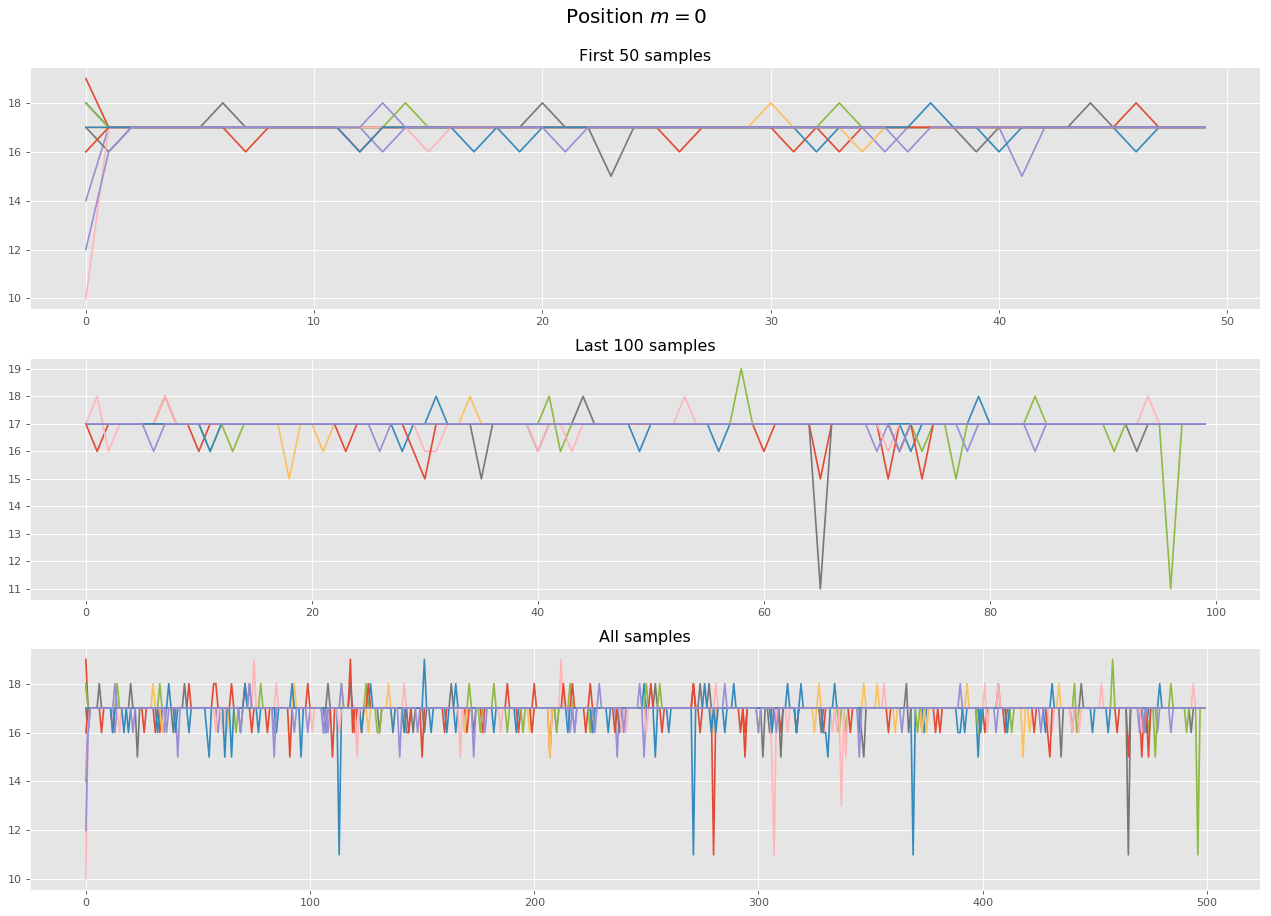

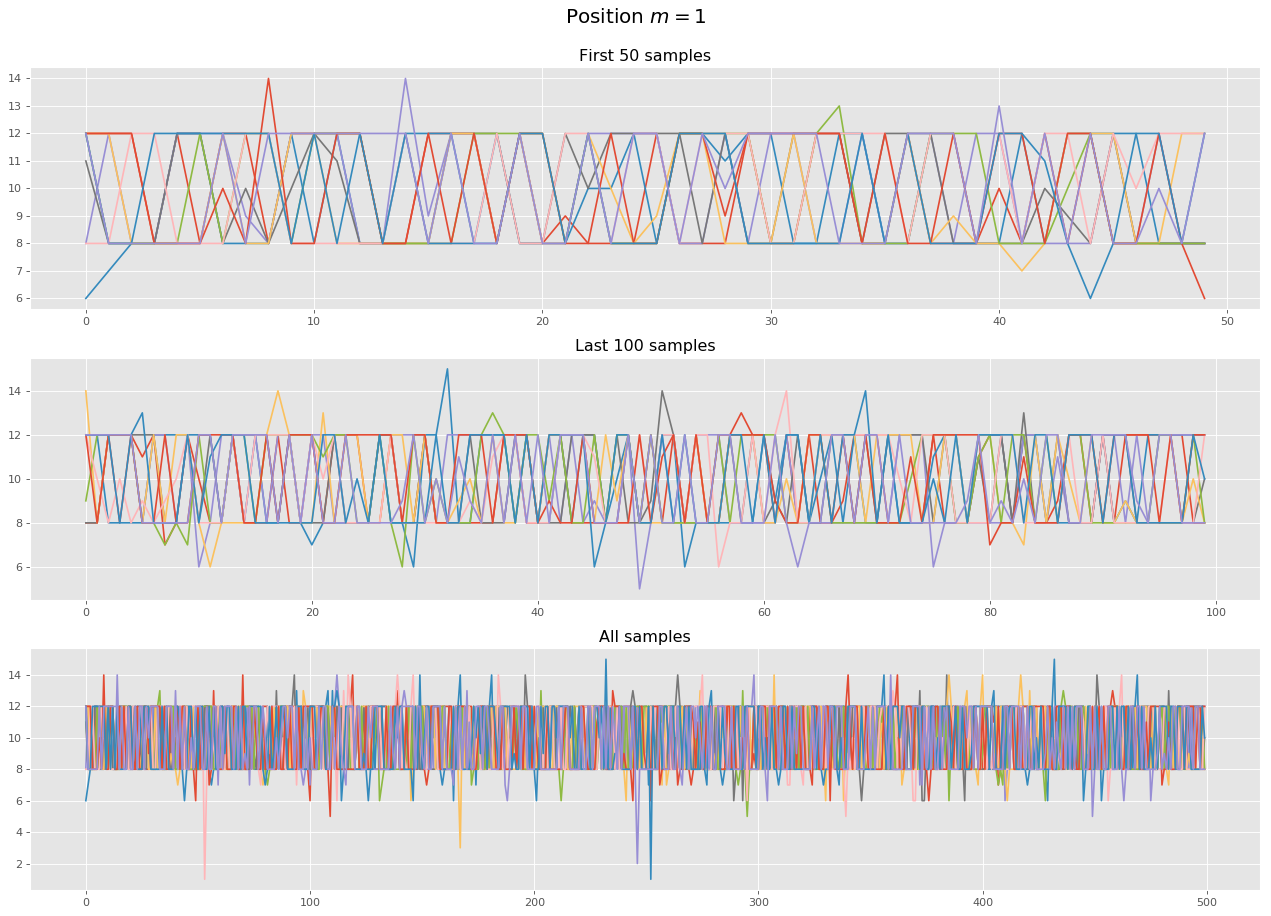

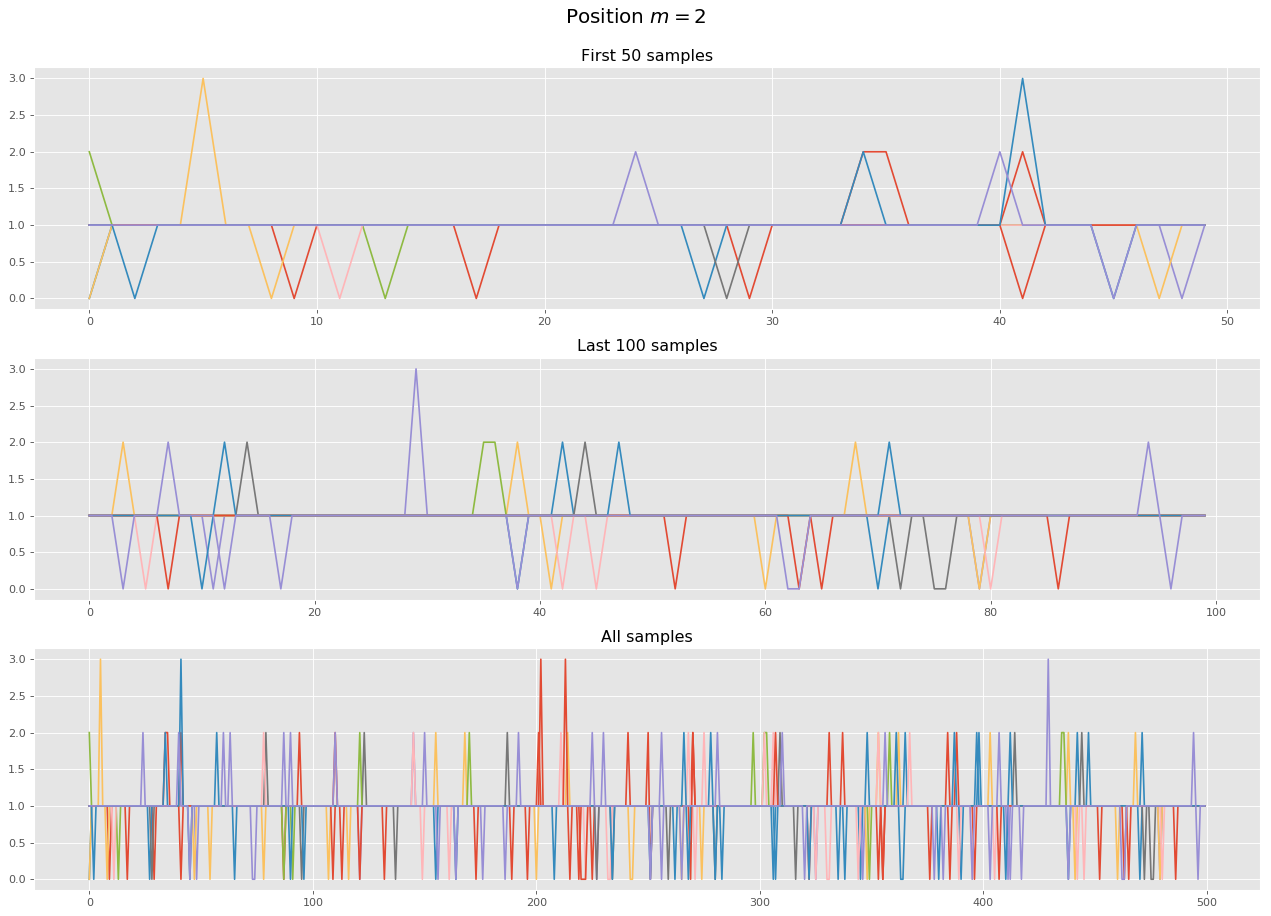

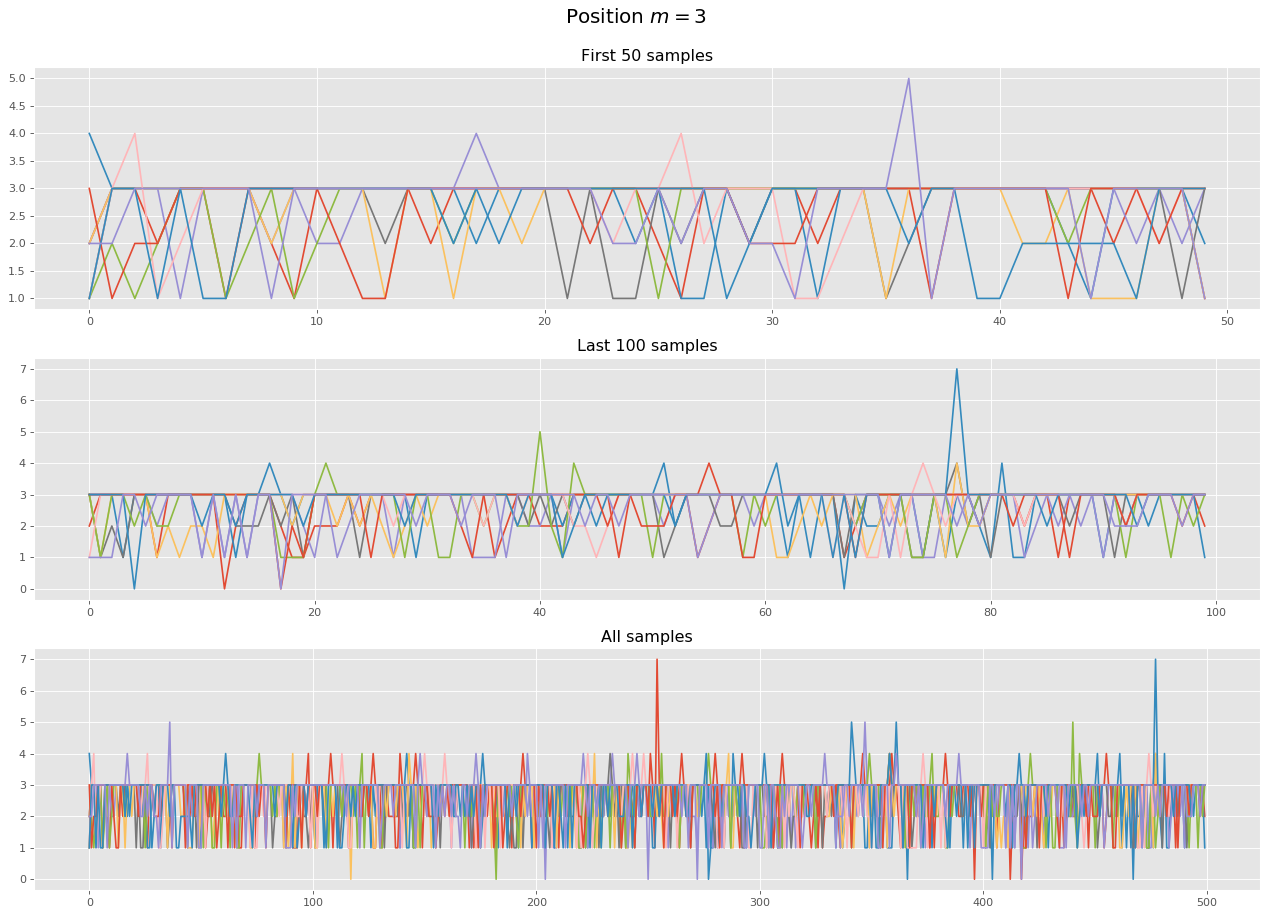

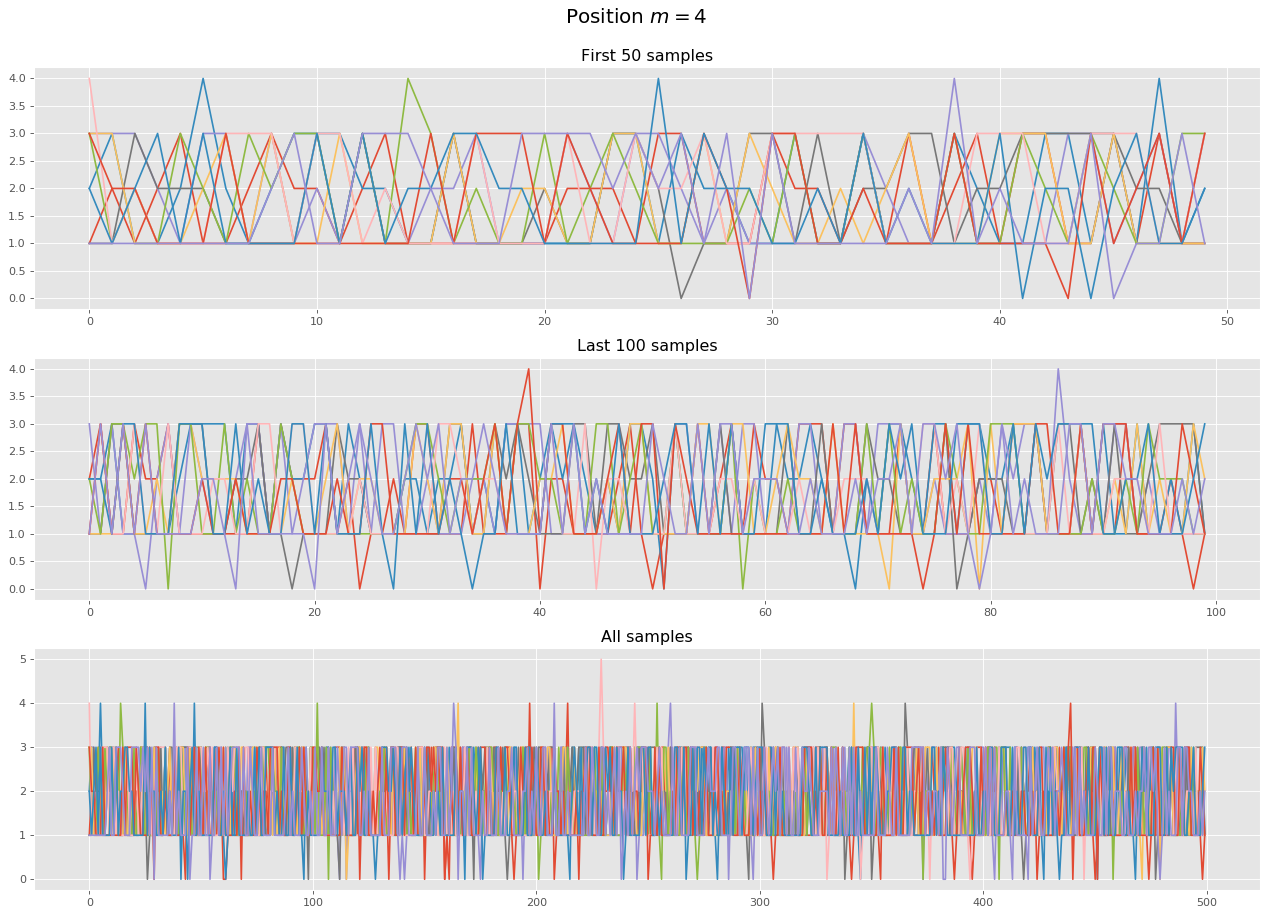

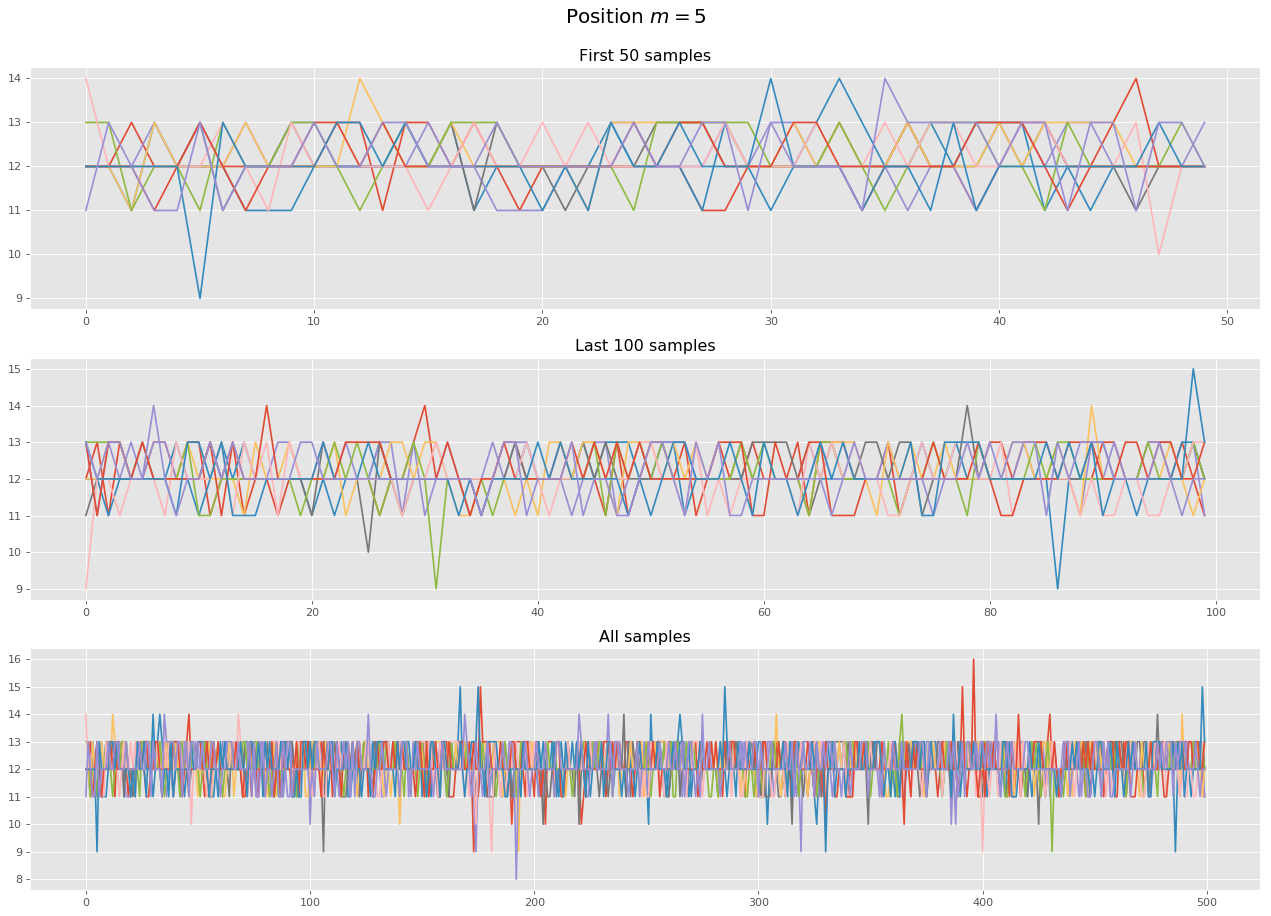

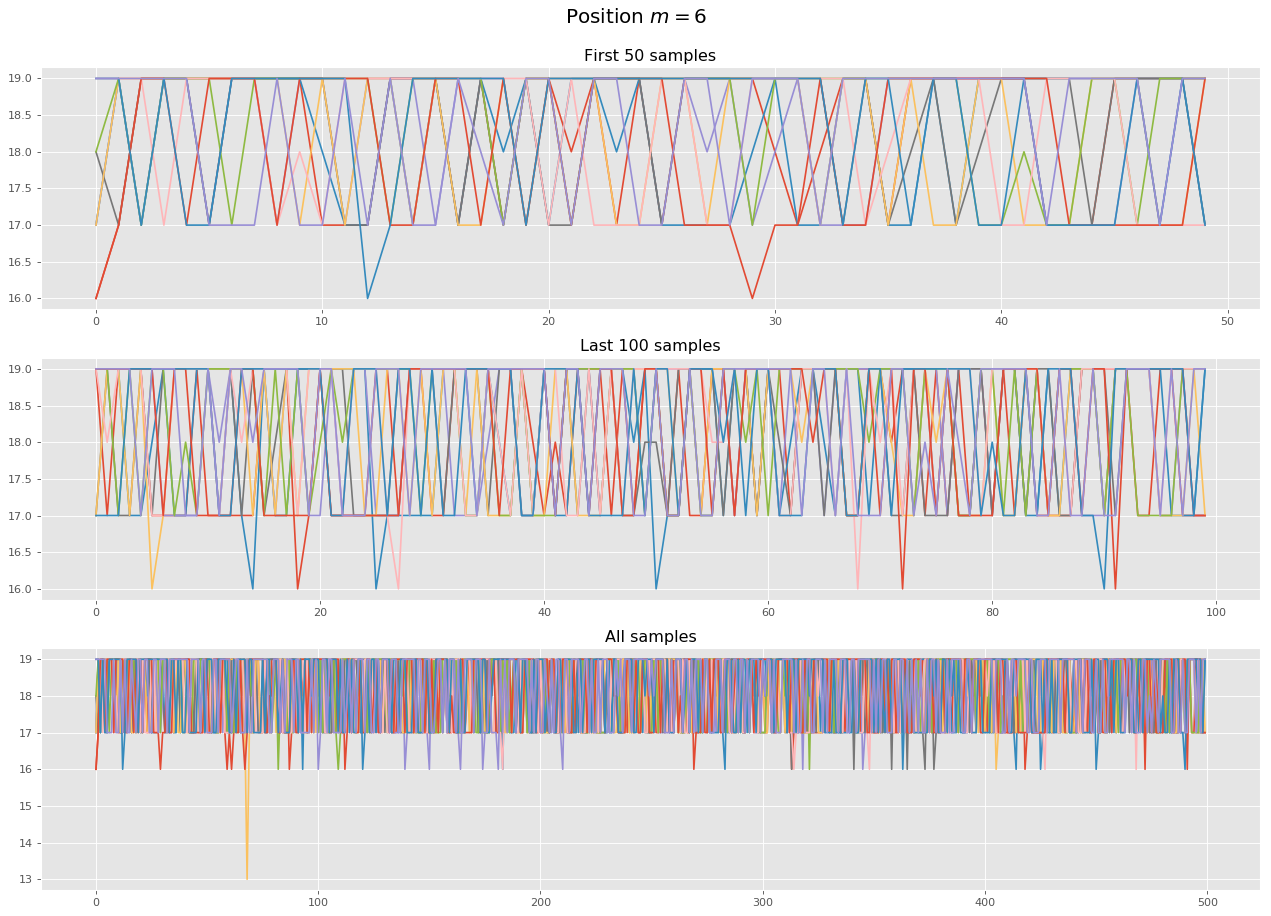

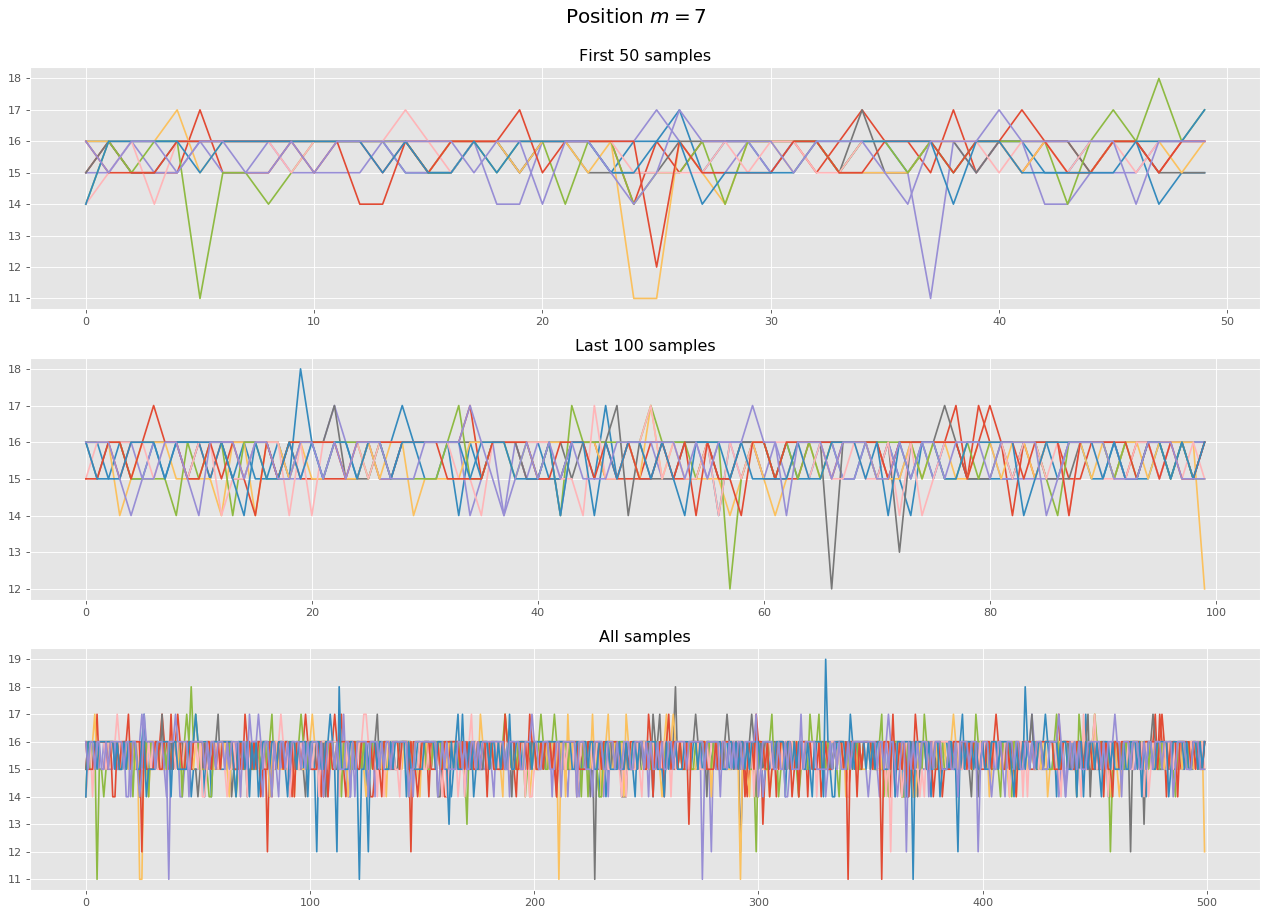

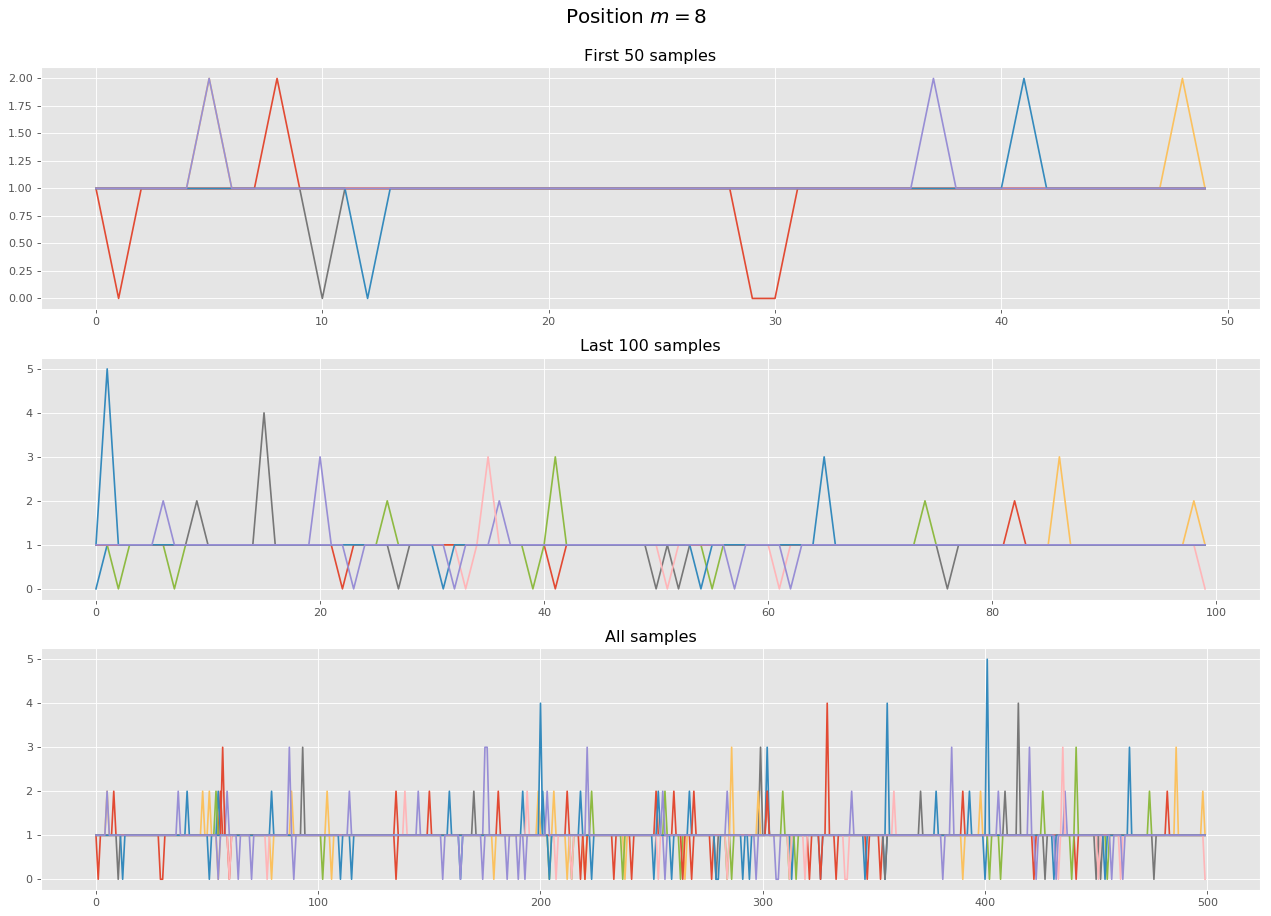

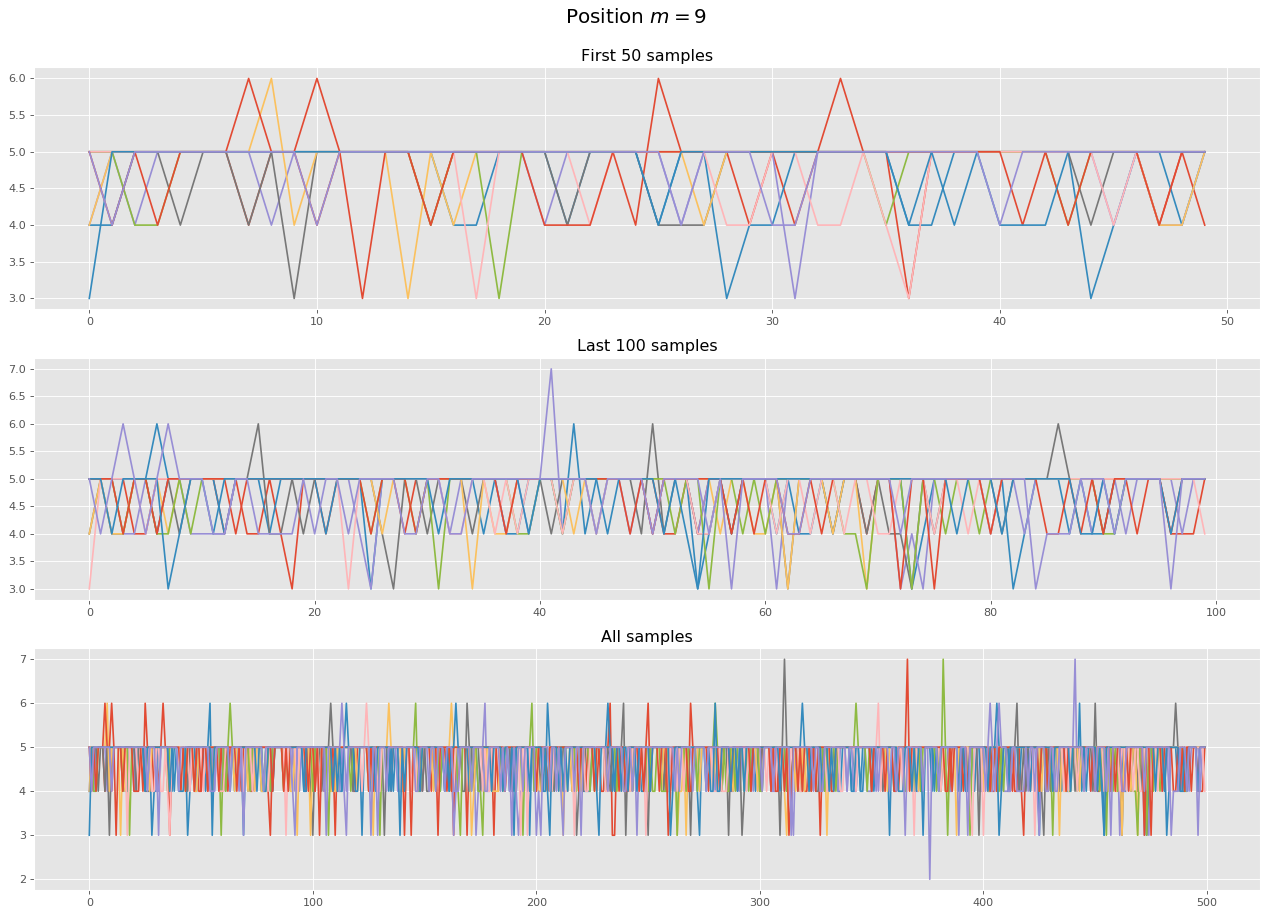

In [123]:
for m in range(N):         # for each position
    f, axarr = plt.subplots(3, 1, figsize=(16, 12), dpi=80)
    for c in range(num_of_chains):
        axarr[0].plot(gs_samples[c,0:50,m],label='$c={}$'.format(c))
        axarr[0].set_title('First {} samples'.format(50))
        
        axarr[1].plot(gs_samples[c,num_of_samples-100:,m],label='$c={}$'.format(c))
        axarr[1].set_title('Last {} samples'.format(100))
        
        axarr[2].plot(gs_samples[c,:,m],label='$c={}$'.format(c))
        axarr[2].set_title('All samples'.format(50))
        
        f.suptitle('Position $m={}$'.format(m), fontsize=18)
        f.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('figures/T_2_4/Q2/convergence_pos{}.png'.format(m))
    plt.show()
    
    

We can also observe the histograms to see the points around which the data gravitate to.

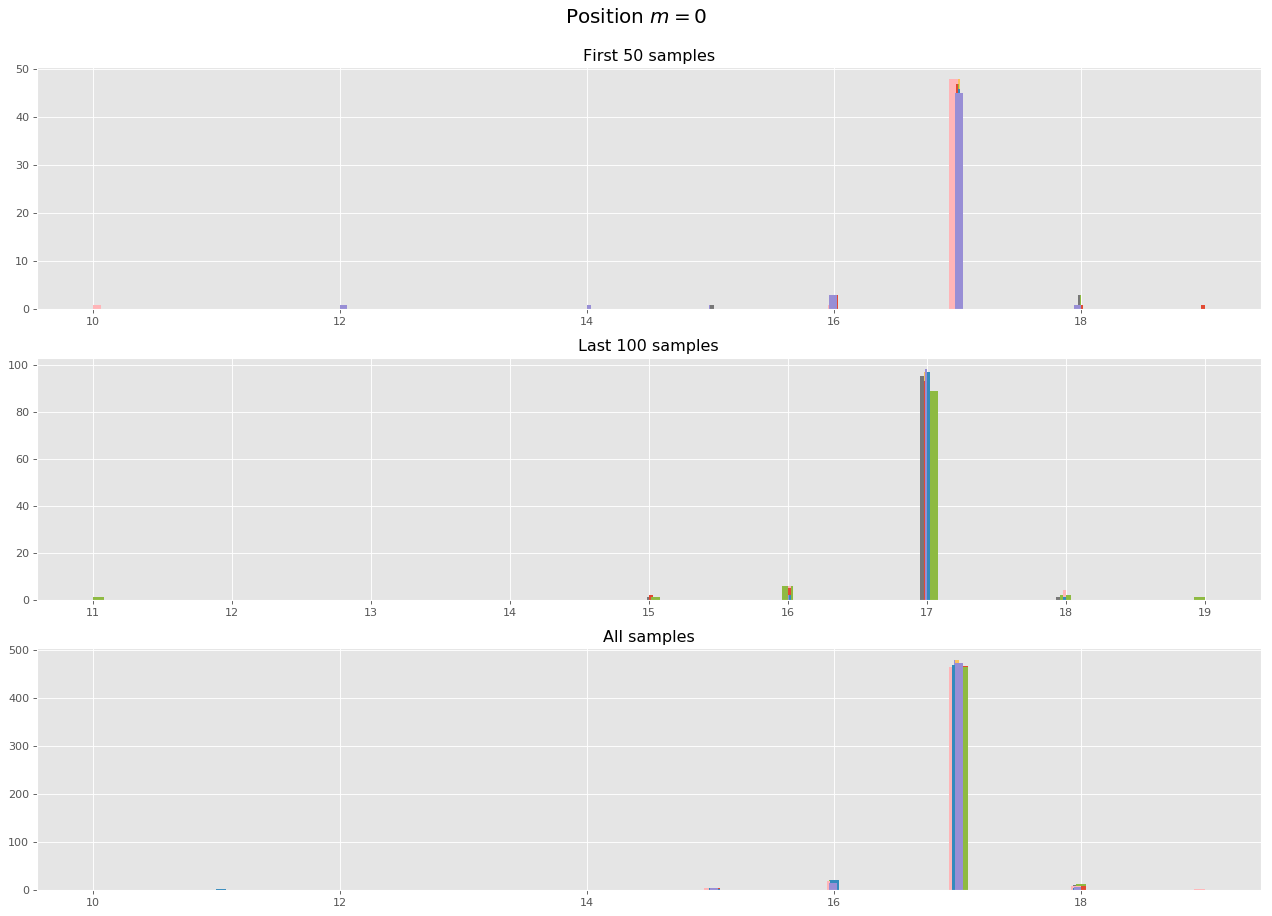

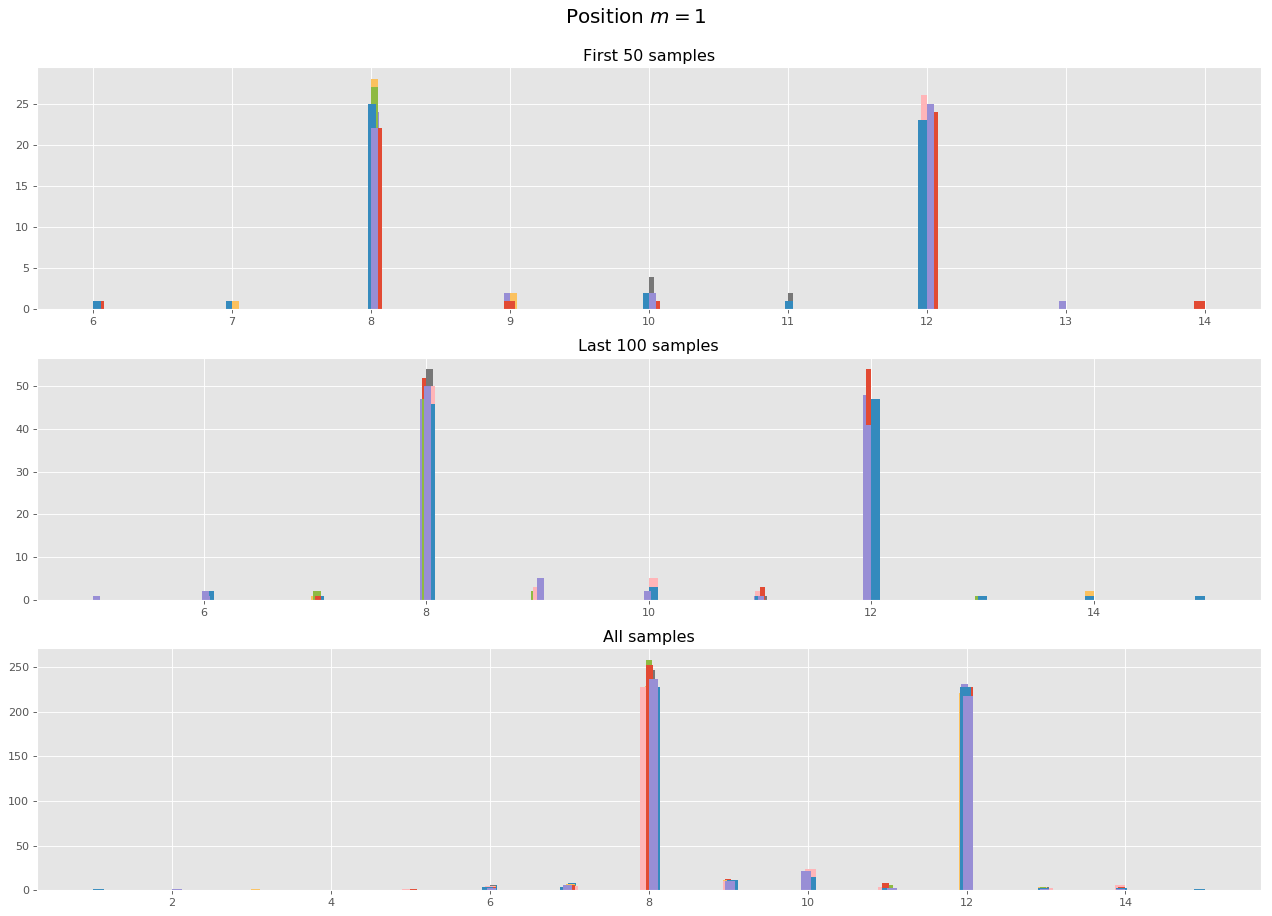

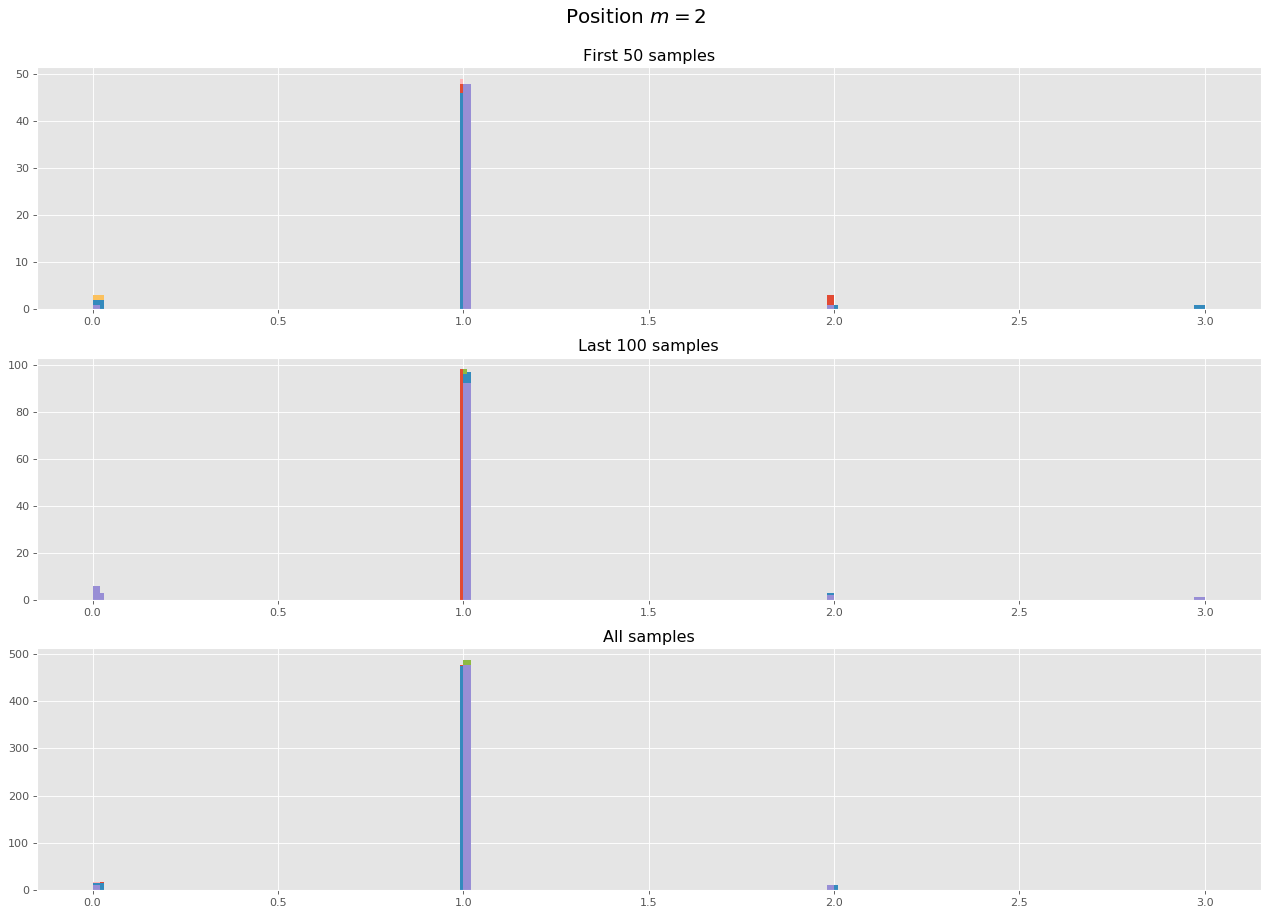

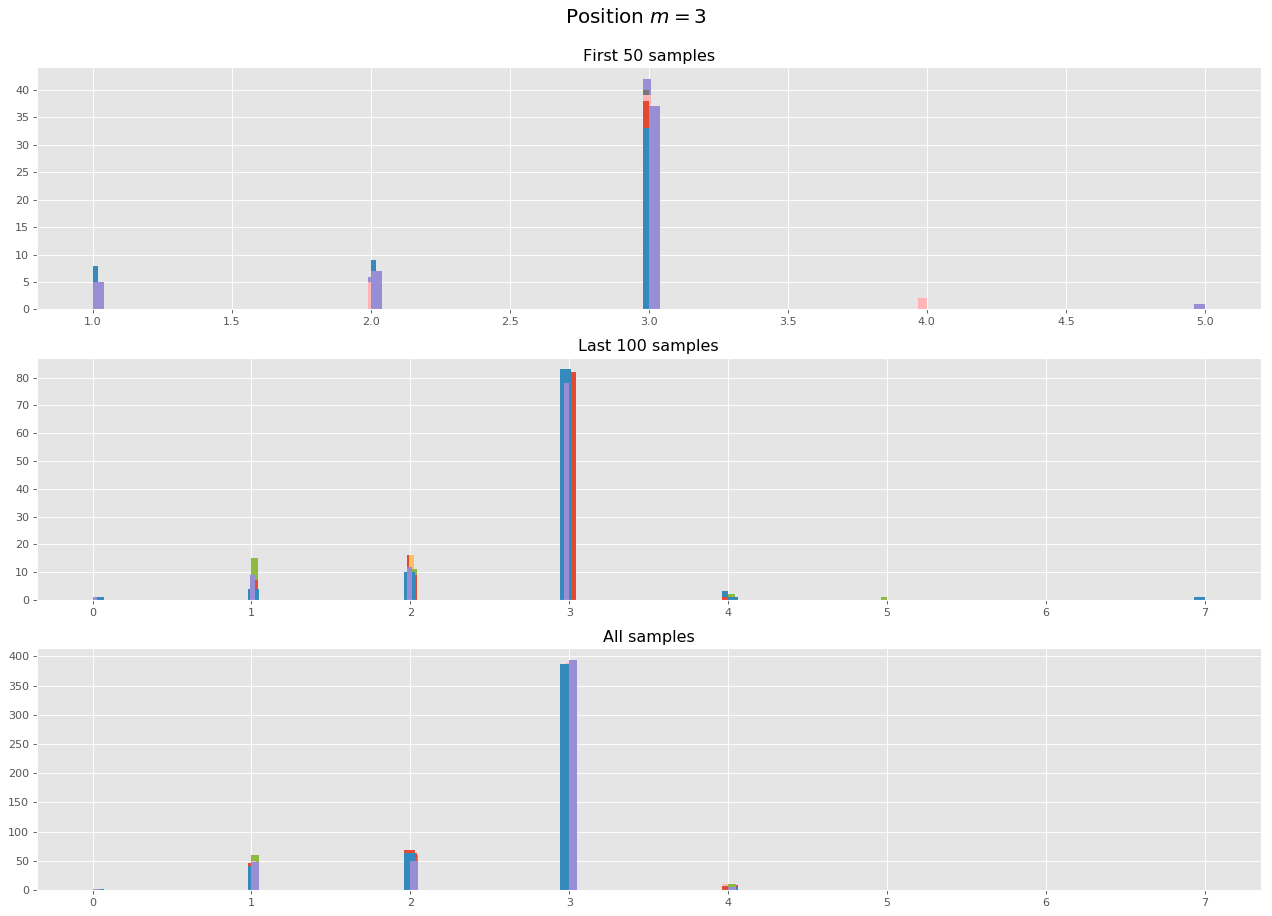

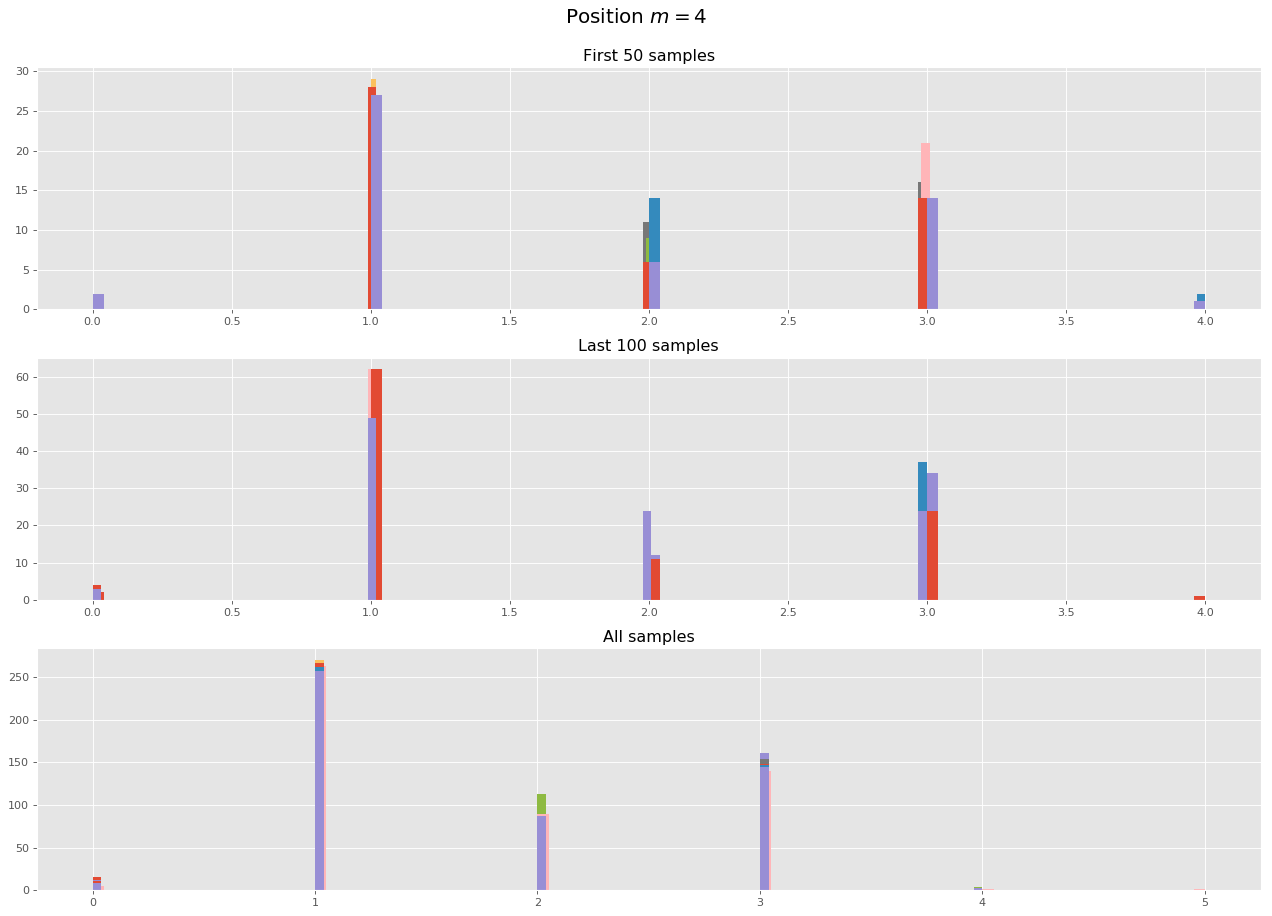

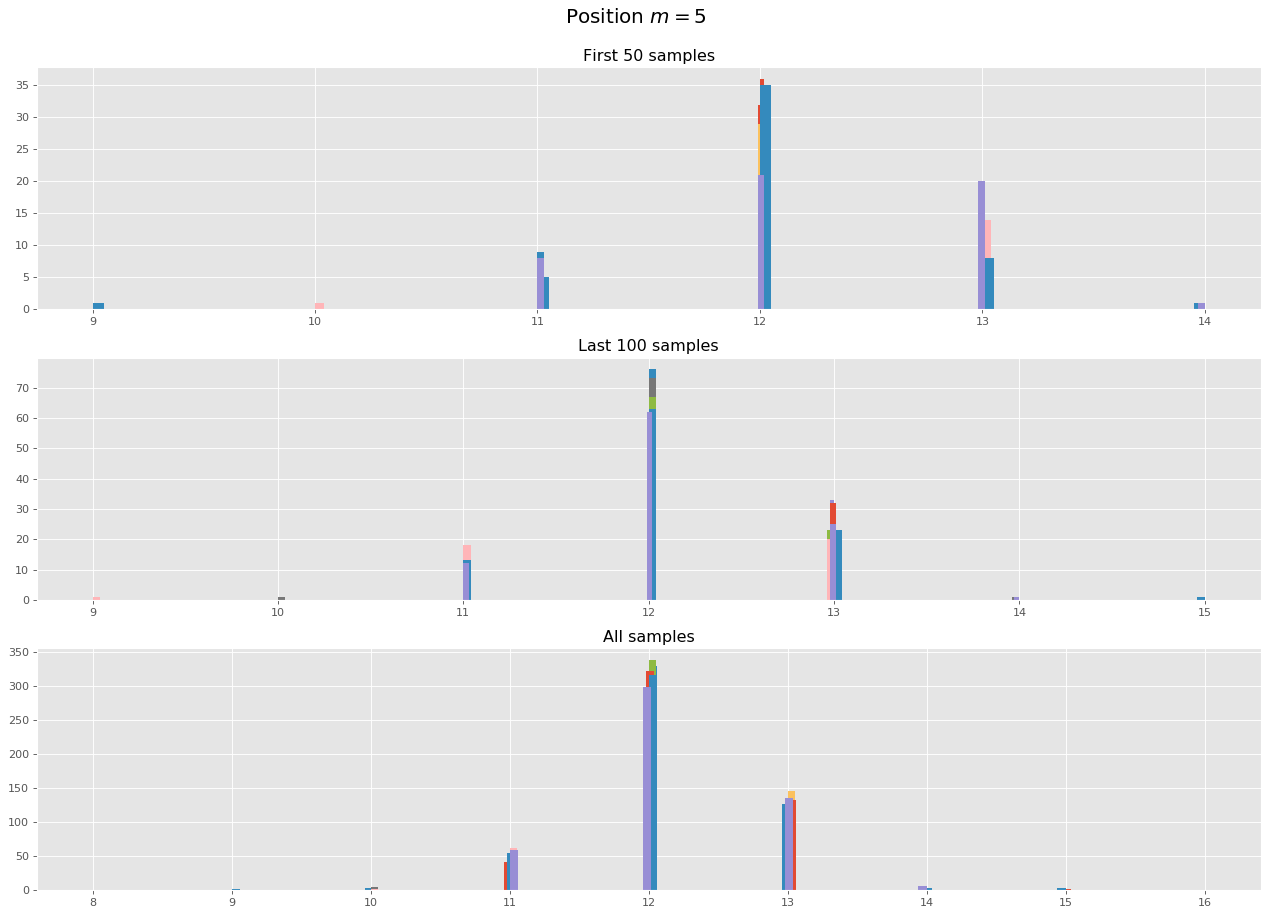

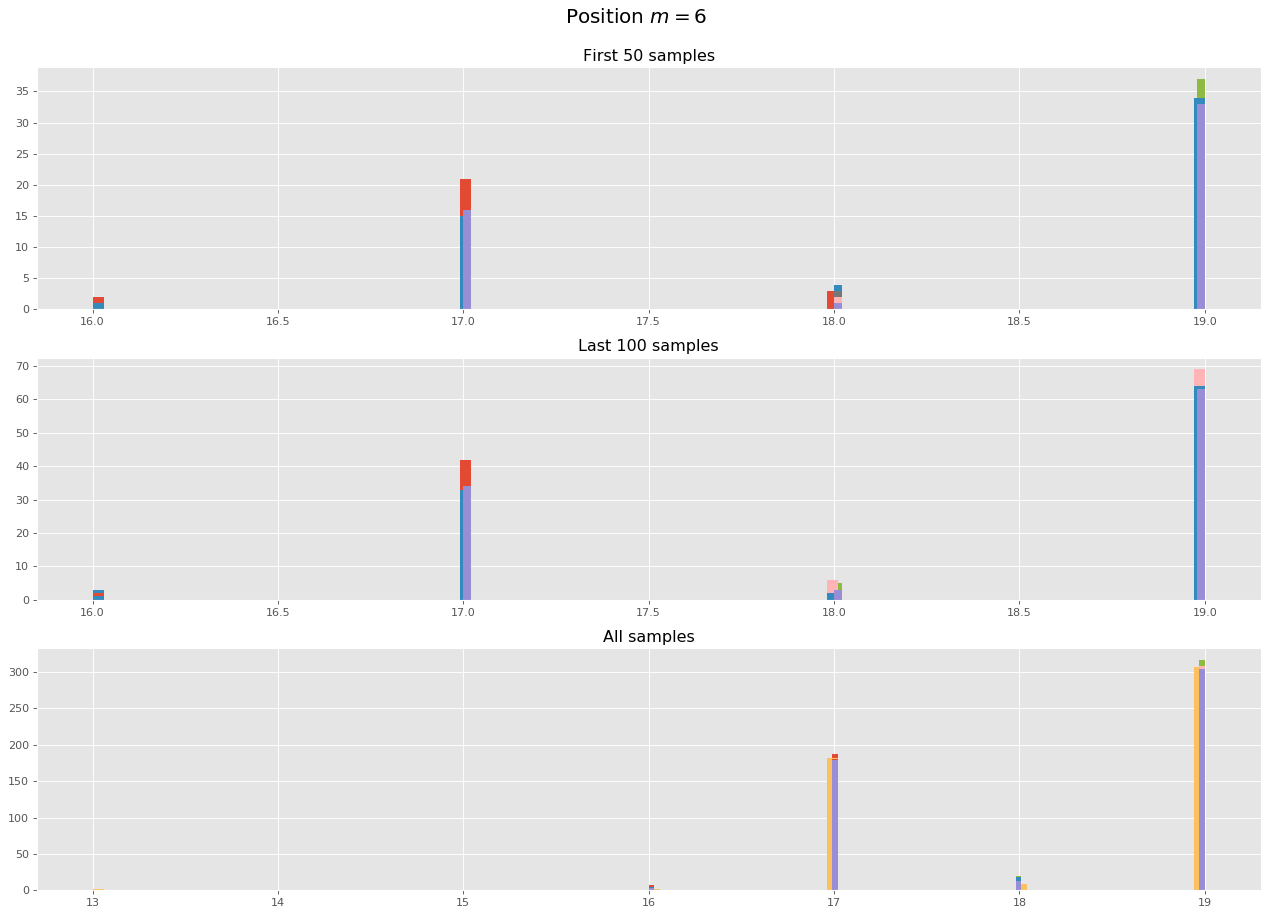

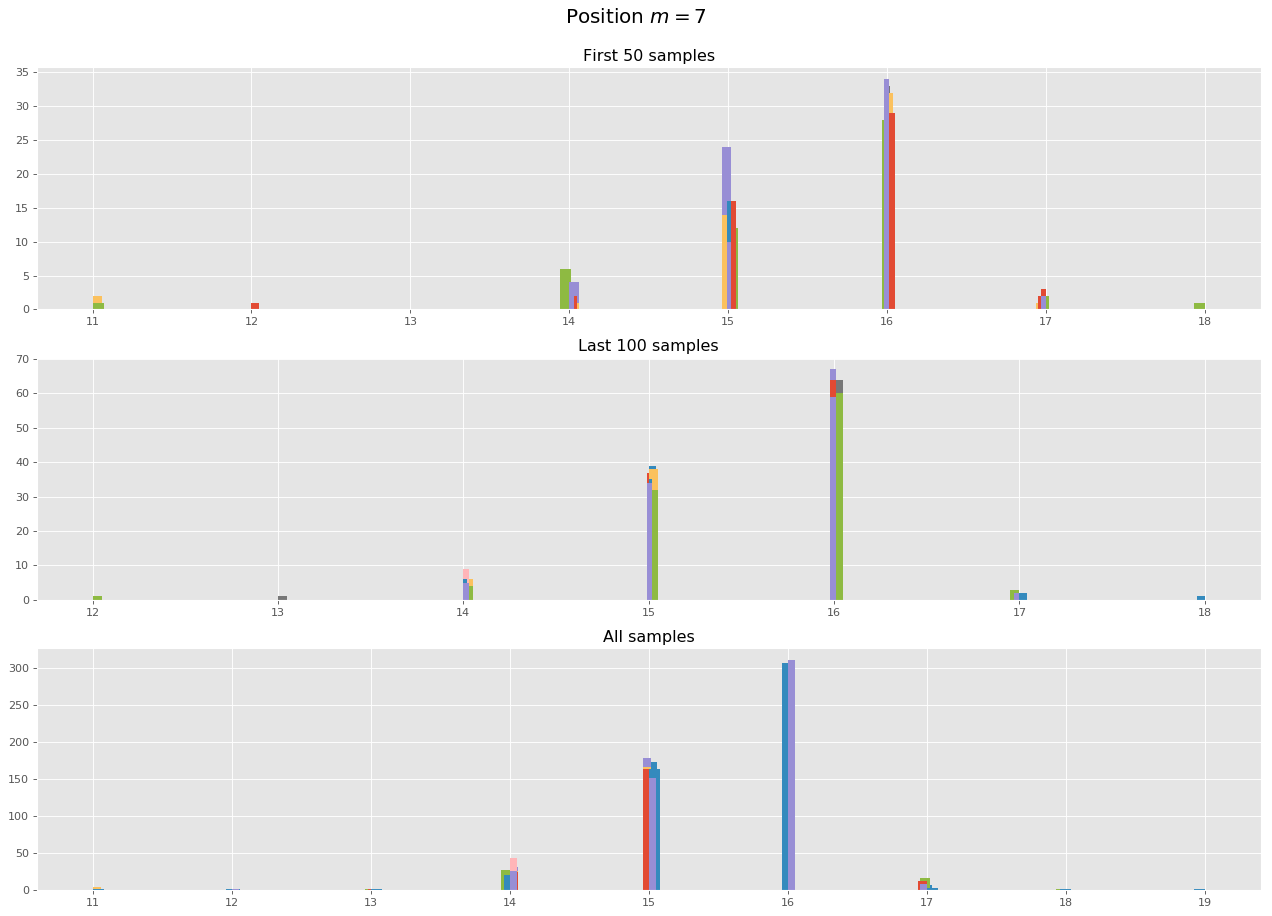

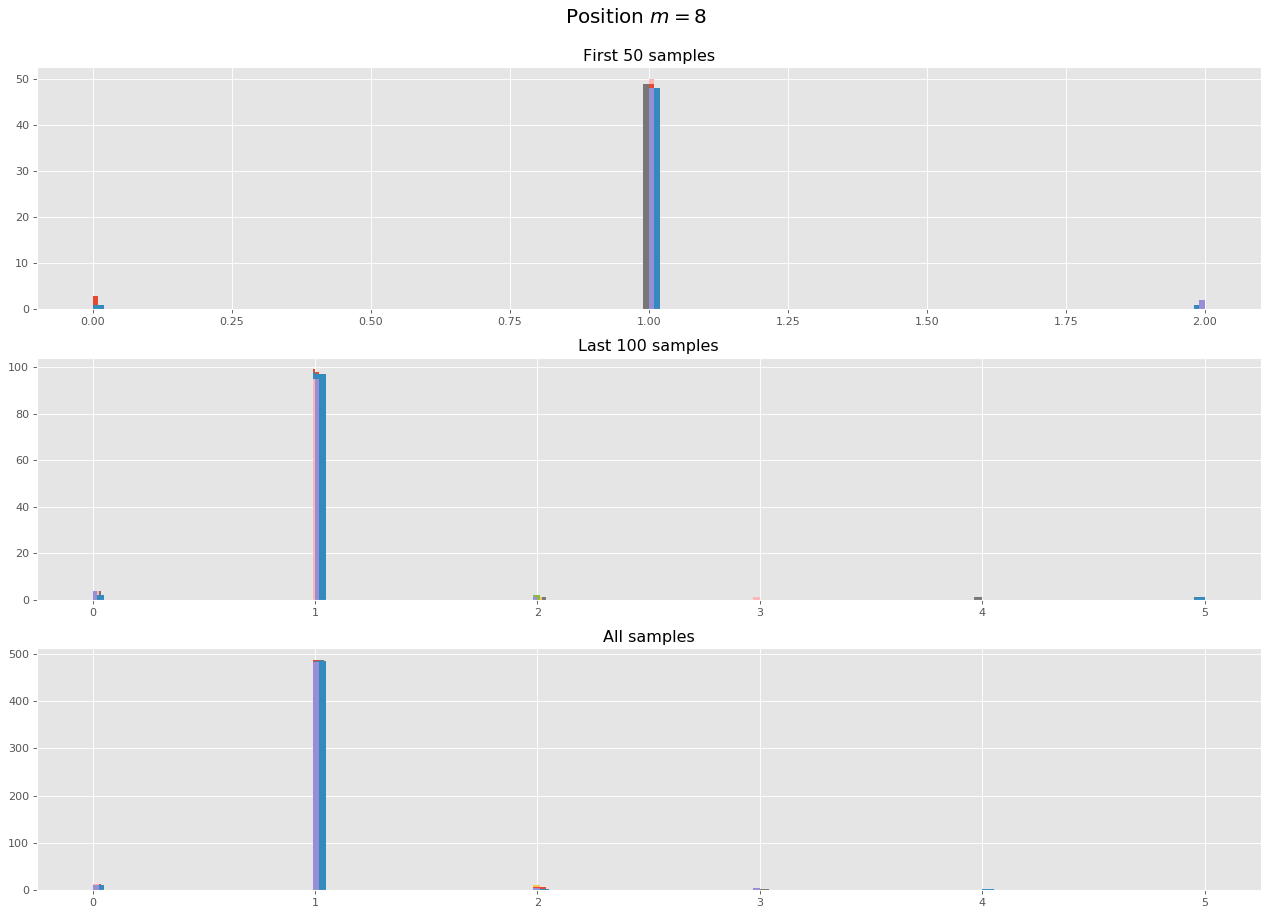

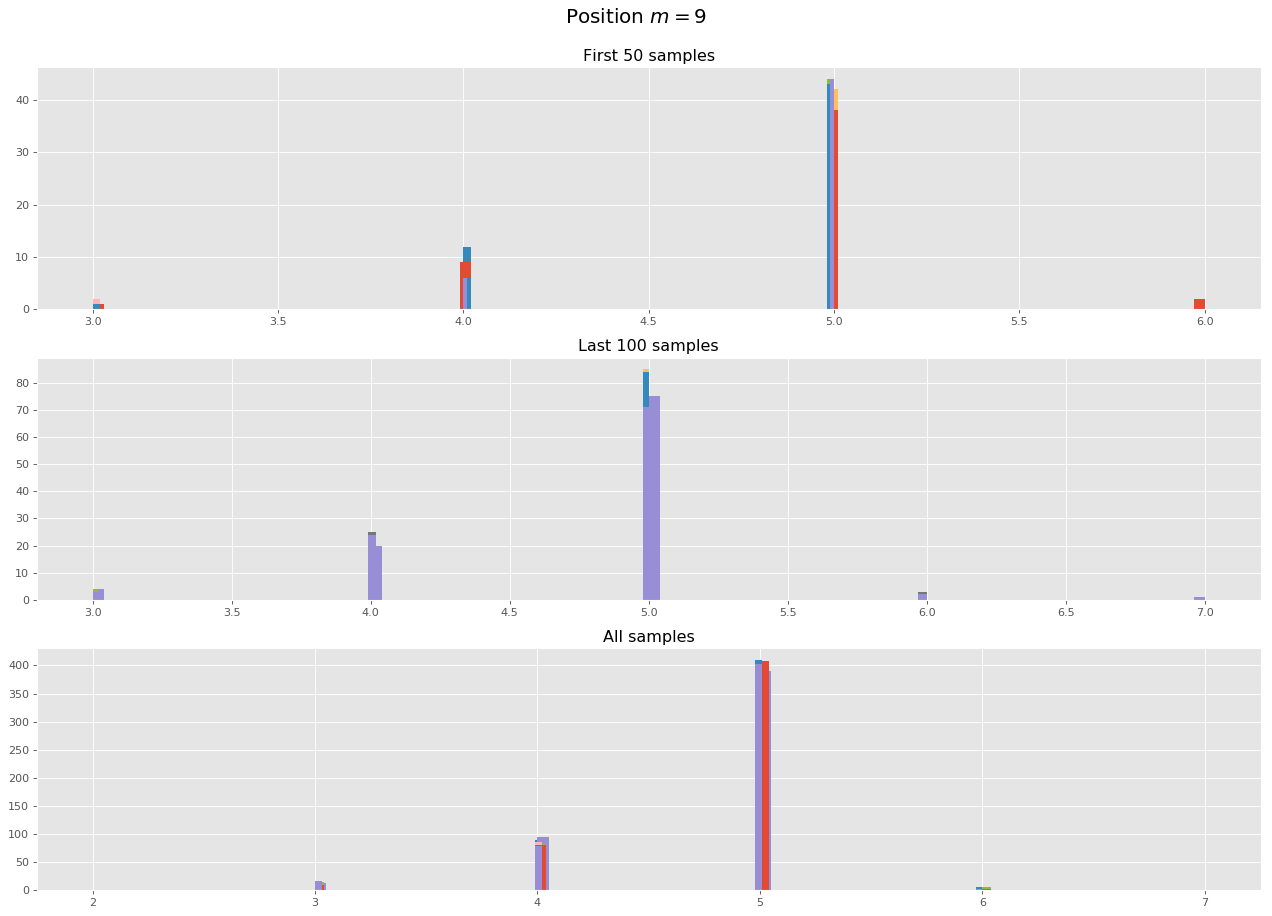

In [124]:
for m in range(N):         # for each position
    f, axarr = plt.subplots(3, 1, figsize=(16, 12), dpi=80)
    for c in range(num_of_chains):
        axarr[0].hist(gs_samples[c,0:50,m],label='$c={}$'.format(c),bins=100)
        axarr[0].set_title('First {} samples'.format(50))
        
        axarr[1].hist(gs_samples[c,num_of_samples-100:,m],label='$c={}$'.format(c),bins=100)
        axarr[1].set_title('Last {} samples'.format(100))
        
        axarr[2].hist(gs_samples[c,:,m],label='$c={}$'.format(c),bins=100)
        axarr[2].set_title('All samples'.format(50))
        
        f.suptitle('Position $m={}$'.format(m), fontsize=18)
        f.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('figures/T_2_4/Q2/distribution_pos{}.png'.format(m))
    plt.show()
    
    

In [72]:
positions

[17, 8, 1, 3, 1, 12, 19, 16, 1, 5]

For a more quantitative overview of this method we can observe the convergence over the positions by using the estimated potential scale reduction statistics. This methods compares the variance of each position within each chain to its variance across chains.

We will evaluate the convergence of our chain over time. For each timestep we recompute the convergence from the beginning up until that point and then plot the convergence rate for each position from the second position until the end.

In [74]:
def epsr(data):
    '''
    Calculate the estimated potential scale reduction statistics for the given list of chain samples of vector varaibles.
    
    data : np.array of dimension CxSxD where C is the number of chains, S the number of samples in each chain and D being the dimension of the sampled variable.
    
    return : float, espr metric
    '''
    C,S,D = data.shape

    y_dotc = np.mean(data,axis=1)
    
    y_dotdot = np.mean(y_dotc,axis=0)
    
    B = S/(C-1.) * np.sum( (y_dotc-y_dotdot)**2, axis=0)
    
    W_inner = np.sum( np.array( [ (data[c,:,:]-y_dotc[c,:])**2 for c in range(C) ] ) , axis=1)
    W = 1./C * np.sum( 1./(S-1) * W_inner ,axis=0)
    
    V_hat = (S-1.)/S * W + 1./S * B
    
    epsr_score = np.sqrt(V_hat / W)
    
    return epsr_score
    
    

In [77]:
C,S,D = gs_samples.shape

In [83]:
convergene_over_time = np.array([ epsr(gs_samples[:,0:t,:]) for t in range(2,S)])

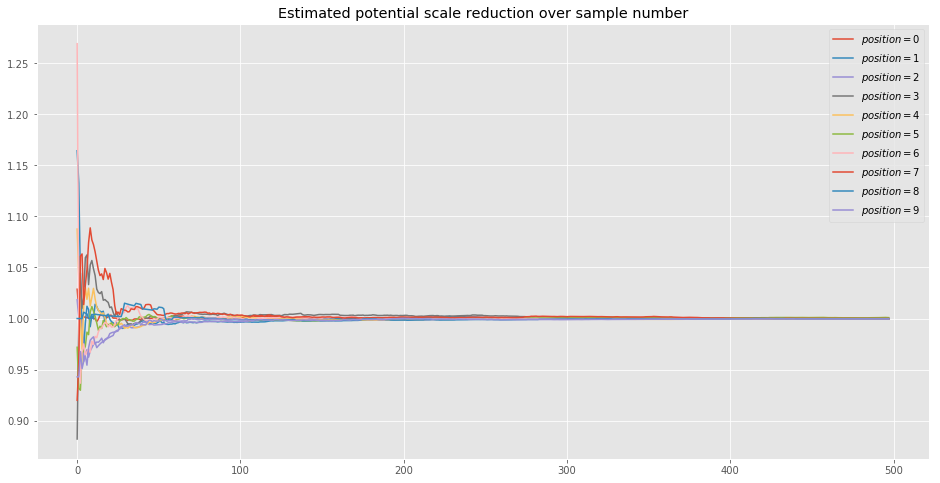

In [125]:
plt.figure(figsize=(16,8))
for pos in range(D): # for each position plot a new graph
    plt.plot(convergene_over_time[:,pos],label='$position = {}$'.format(pos))
plt.title('Estimated potential scale reduction over sample number')
plt.legend(loc=1)
plt.savefig('figures/T_2_4/Q2/convergence_epsr.png')   
plt.show()

We observe that the convergence happens under 100 samples.

For accuracy we will introduce a metrics to evaluate how the performance of each chain changes over time. Since we are provided the true initial positions of the magic word we are estimating, we can compute the mean squared error for each sample.

In [113]:
se = (gs_samples-positions)**2

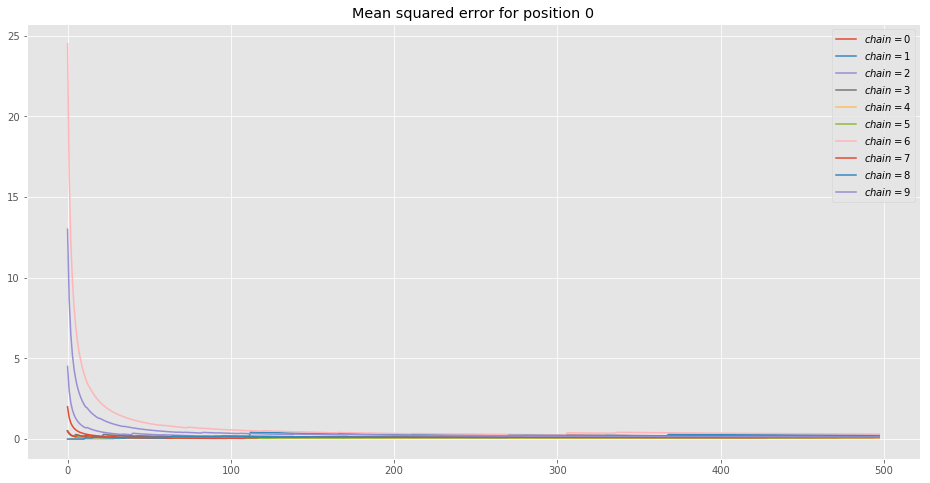

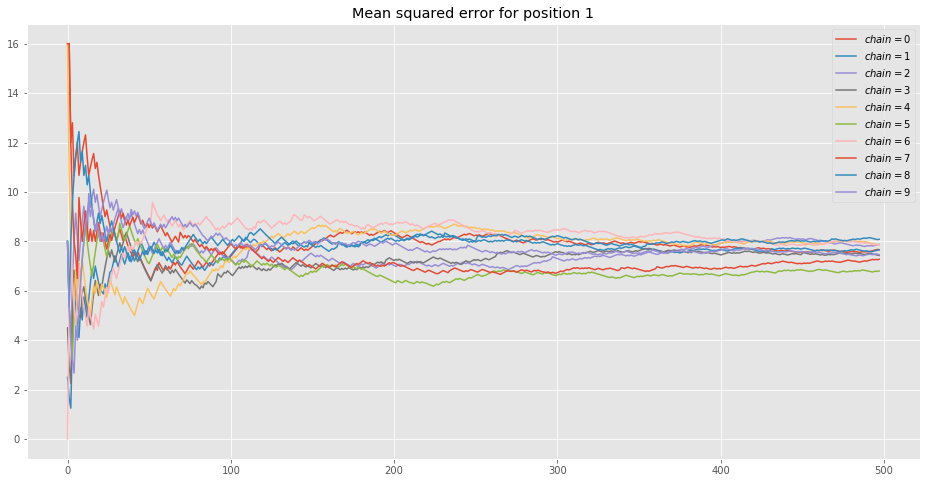

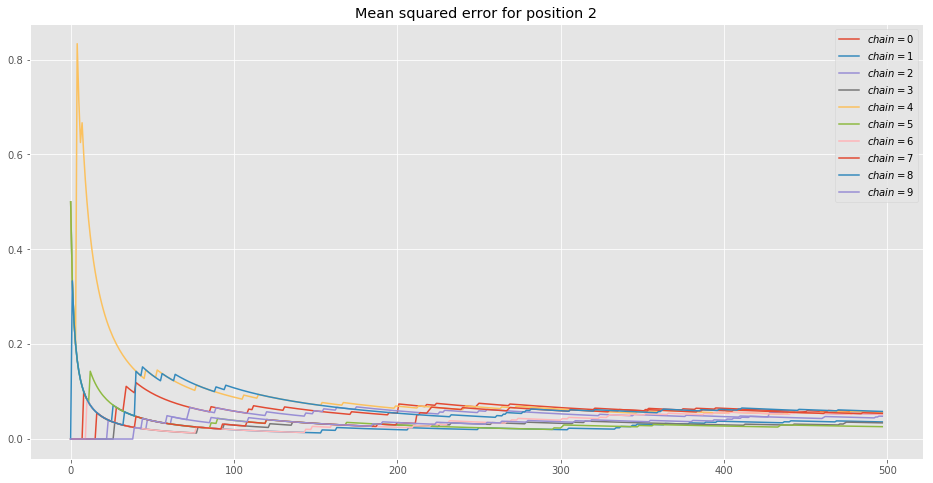

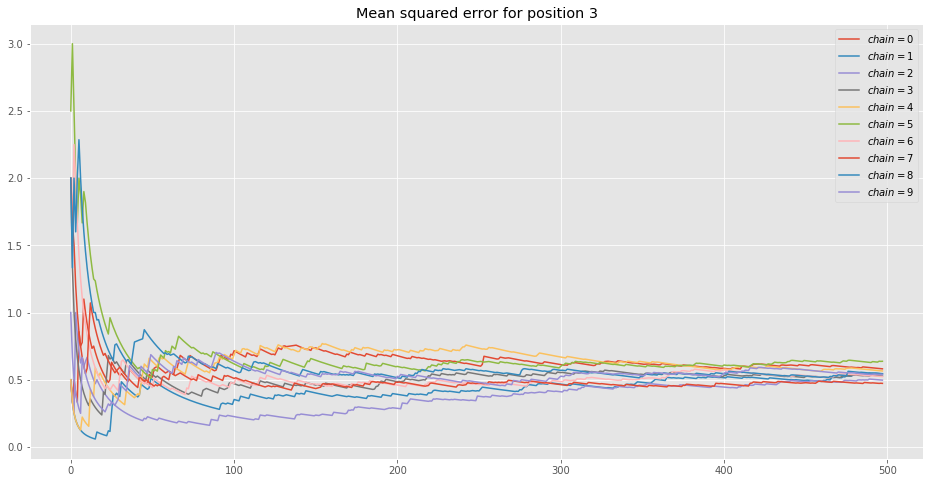

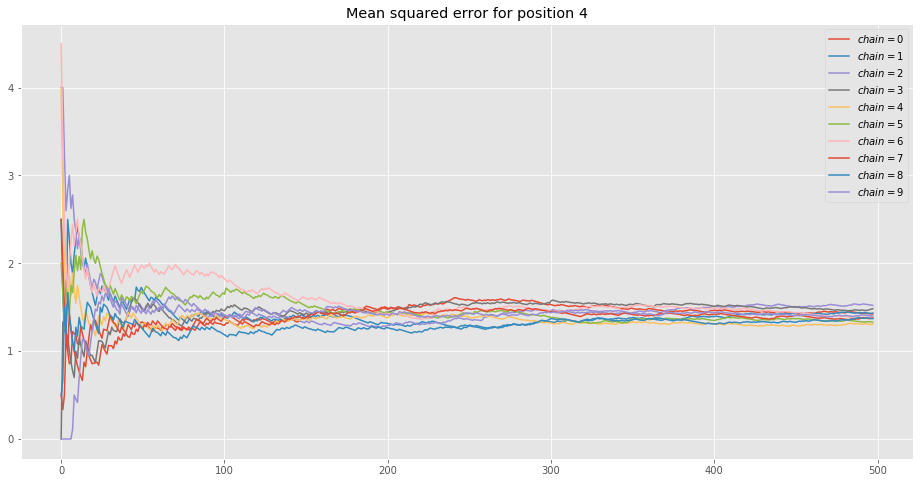

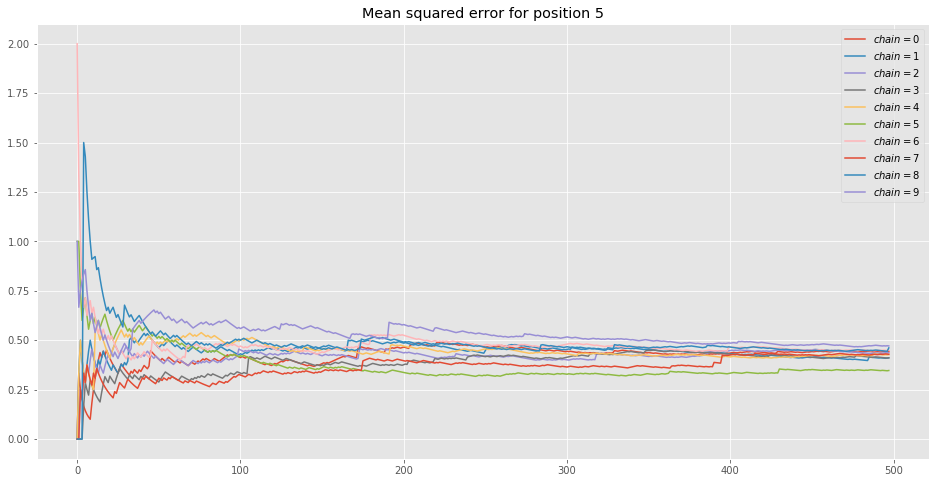

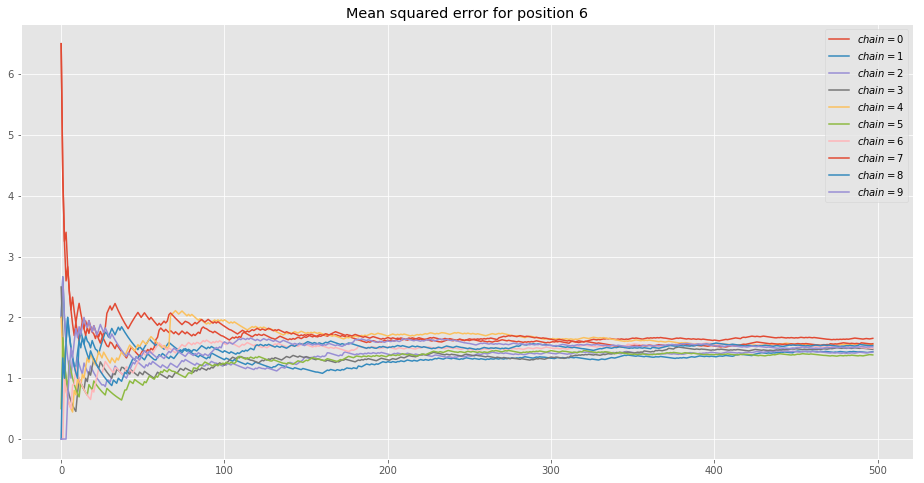

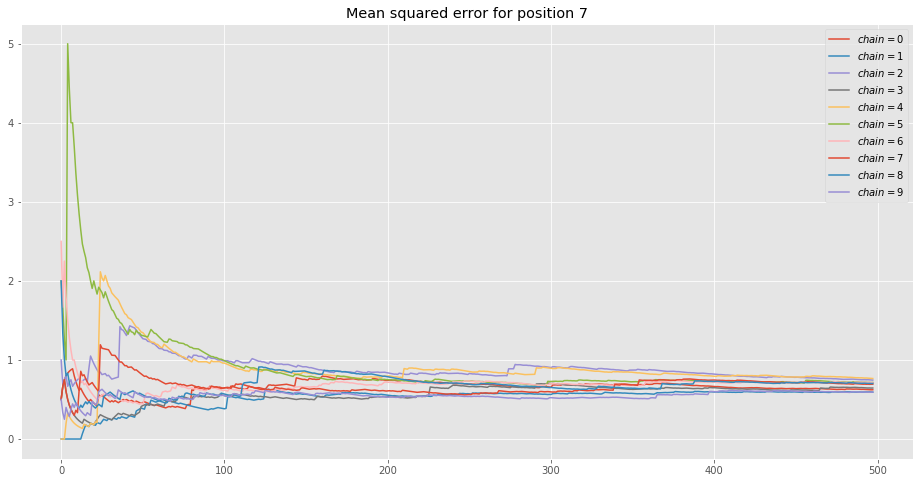

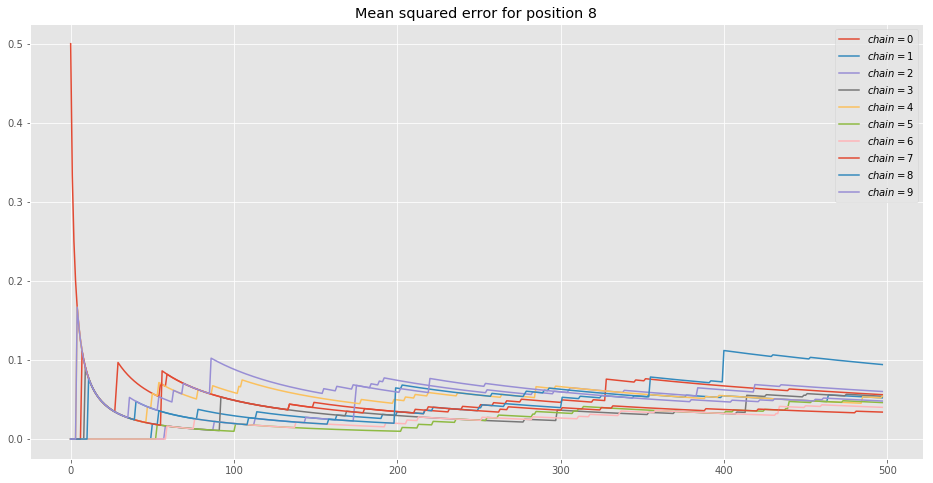

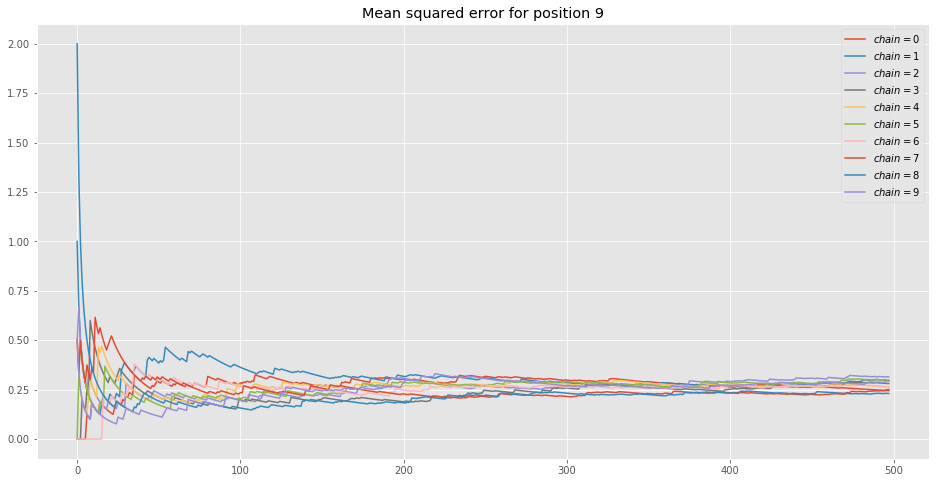

In [126]:
for pos in range(D): # for each position plot a new graph
    plt.figure(figsize=(16,8))
    for chain in range(C):
        mse = [ np.mean(se[chain,:t,pos]) for t in range(2,S)]
        plt.plot(mse,label='$chain={}$'.format(chain))
        
    plt.title('Mean squared error for position {}'.format(pos))
    plt.legend(loc=1)
    plt.savefig('figures/T_2_4/Q2/mse_pos{}.png'.format(pos))   
    plt.show()

We observe that the error is gradualy diminishing and converging to a specific value due to the reduction of the variance over time. Still for the positions on which the sampler remain undecisive such as position 1 and 4 the error remains high. 

---